# Initialization

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
from IPython.display import display, clear_output
from tqdm.auto import tqdm
import torch.nn.functional as F
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.profiler import profile, record_function, ProfilerActivity
from datagen import pseudoset as pseudoset
import numpy as np
import pickle
import os
import sys
from datagen.genset import GenSet
import time

ROOT = os.path.join("./")
sys.path.append(ROOT + "lib")
sys.path.append(ROOT + "models")
sys.path.append(ROOT + "datagen")

from helpers import *
from sourceset import SourceSet
from fourier import *
from cnn import CNN
from transformer import *
from final import *
from general_trainer import compete, gen_train, itertrain
torch.multiprocessing.set_start_method('spawn')

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
torch.set_default_dtype(torch.float32)
device

'cuda'

In [2]:
# with open(ROOT + "processed_datasets/pseudotrain.pt", "rb") as f:
#   data_train = torch.load(f, map_location=device)
# with open(ROOT + "processed_datasets/pseudovalid.pt", "rb") as f:
#   data_valid = torch.load(f, map_location=device)

# # train = DataLoader(data_train, batch_size=None, shuffle=True, generator=torch.Generator(device=device))
# valid = DataLoader(data_valid, batch_size=None, shuffle=False, generator=torch.Generator(device=device))

# # with open(ROOT + "processed_datasets/data_train.pt", "rb") as f:
# #   data_train = torch.load(f, map_location=device)
with open(ROOT + "processed_datasets/agglomerated_data_valid.pt", "rb") as f:
  data_valid = torch.load(f, map_location=device)

# train = DataLoader(data_train, batch_size=40, shuffle=True, generator=torch.Generator(device=device), collate_fn=padded_collate)
valid = DataLoader(data_valid, batch_size=len(data_valid), shuffle=False, generator=torch.Generator(device=device), collate_fn=tracking_validation_collate)

data_train = GenSet(1600, 100, 0, aggfreq=True, prop=[0.4,0.2,0.2,0.2])
# data_valid = GenSet(256, 256, 0, True)
traini = DataLoader(data_train, batch_size=None, num_workers=4)
# validi = DataLoader(data_valid, batch_size=None)

In [3]:
kwargs = dict(samples=1024, out=3, learnsamples=True)
model = CNFourierModel(**kwargs).to(device)
model_pars = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_pars])

for p in model.named_parameters():
    print(p[0], np.prod(p[1].size()))
print(params)

cnn1.weight 864
cnn1.bias 24
cnn2.weight 8064
cnn2.bias 48
cnn3.weight 3360
cnn3.bias 10
cnn4.weight 50
cnn4.bias 1
layerone.weight 524288
layerone.bias 512
layertwo.weight 131072
layertwo.bias 256
layerthree.weight 768
layerthree.bias 3
fdft.freqs 1024
norm.weight 256
norm.bias 256
670856


# Training Loop (Single)

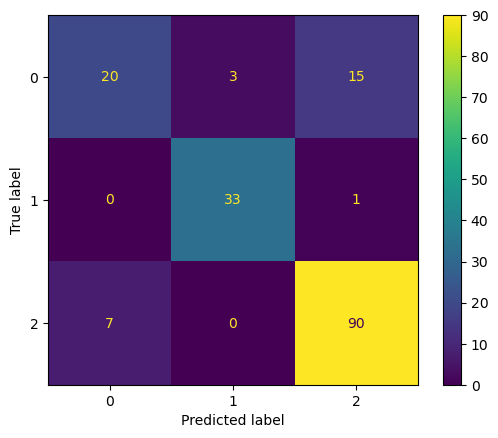

top 5 faileds of valid:  [('null24', [1826, tensor([0.0000e+00, 1.0000e+00, 1.8250e+03], device='cuda:0')]), ('HD 165459', [1823, tensor([0.0000e+00, 1.0000e+00, 1.8220e+03], device='cuda:0')]), ('TV Lyn', [1819, tensor([1.8180e+03, 1.0000e+00, 0.0000e+00], device='cuda:0')]), ('VZ Vir', [1819, tensor([1.8180e+03, 1.0000e+00, 0.0000e+00], device='cuda:0')]), ('NPM1p68_0422', [1818, tensor([0.0000e+00, 1.0000e+00, 1.8170e+03], device='cuda:0')])]


KeyboardInterrupt: 

In [4]:
# clear the cache
torch.random.manual_seed(1)
torch.cuda.empty_cache()
kwargs = dict(samples=1024, out=3, learnsamples=True)
model = CNFourierModel(**kwargs).to(device)
# kwargs = dict(out=4)
# model = CNN(**kwargs).to(device)
optim = torch.optim.AdamW(model.parameters(), lr=0.00001, weight_decay=10**-5, amsgrad=True)
loss = torch.nn.CrossEntropyLoss().to(device)
# gen_train(model, kwargs, optim, loss, train, validi, 100, False, tracking=False)
itertrain(model, kwargs, optim, loss, traini, valid, 250, 30, tracking=True)

In [ ]:
for ex, l in traini:
    print(torch.isnan(ex).any())

# Model

In [ ]:
# Valid dataloader as list is comprised of ( (N x T x F), N x Label )
datas = [pair[0] for pair in valid]
labels = [pair[1] for pair in valid]
validaccessor = (torch.concat(datas, dim = 0), torch.concat(labels, dim = 0)) # Now just (# of exs) x T x F

selector = 8
pair = (validaccessor[0][selector], validaccessor[1][selector])

plot_from_tensor(pair[0])


or

In [ ]:
higher = FourierModel(512,3,learnsamples=True)
lower = FourierModel2(512,3,learnsamples=True)

optim1 = torch.optim.AdamW(higher.parameters(), lr=0.00004, weight_decay=10**-5.5, amsgrad=True)
optim2 = torch.optim.AdamW(lower.parameters(), lr=0.00004, weight_decay=10**-5.5, amsgrad=True)

compete([("amsgrad no", higher, optim1), ("amsgrad yes", lower, optim2)], 500, train, valid)

# Analyze

In [10]:
torch.cuda.empty_cache()
# model = AnomalyDetector(emb_dim=16, out=4).to(device)
kwargs = dict(samples=1024,out=4)
model = CNFourierModel(**kwargs).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)

traini = GenSet(1024, 1024, aggfreq=True)
ex = next(iter(traini))[0]
model.eval()

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
    with record_function("fiojsda"):
      out = model(ex)

ex2 = next(iter(traini))[0]
t1 = time.perf_counter()
out = model(ex2)
t2 = time.perf_counter()
print("Total Time Elapsed - {}ms".format(t2-t1) * 1000)
      
# for n, p in model.named_parameters():
#   print(n)
#   print(p.grad.norm().item())

# plot_grad_flow(model.cpu().named_parameters())

# print("TOTAL TIME: ", (t2-t1) * 10**3, "ms")
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=8))

STAGE:2024-02-20 13:10:54 21778:21778 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2024-02-20 13:10:54 21778:21778 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-02-20 13:10:54 21778:21778 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Total Time Elapsed - 0.002356313169002533msTotal Time Elapsed - 0.002356313169002533msTotal Time Elapsed - 0.002356313169002533msTotal Time Elapsed - 0.002356313169002533msTotal Time Elapsed - 0.002356313169002533msTotal Time Elapsed - 0.002356313169002533msTotal Time Elapsed - 0.002356313169002533msTotal Time Elapsed - 0.002356313169002533msTotal Time Elapsed - 0.002356313169002533msTotal Time Elapsed - 0.002356313169002533msTotal Time Elapsed - 0.002356313169002533msTotal Time Elapsed - 0.002356313169002533msTotal Time Elapsed - 0.002356313169002533msTotal Time Elapsed - 0.002356313169002533msTotal Time Elapsed - 0.002356313169002533msTotal Time Elapsed - 0.002356313169002533msTotal Time Elapsed - 0.002356313169002533msTotal Time Elapsed - 0.002356313169002533msTotal Time Elapsed - 0.002356313169002533msTotal Time Elapsed - 0.002356313169002533msTotal Time Elapsed - 0.002356313169002533msTotal Time Elapsed - 0.002356313169002533msTotal Time Elapsed - 0.002356313169002533msTotal Time 